In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
%%time

fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
cat = 2
if year == 2016:
    path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_8_0_21/src/cms_lpc_llp/llp_ntupler/ntuples/'
    file_name = 'displacedJetMuon_ntupler_RunIISummer16'
elif year == 2017:
    path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_7/src/cms_lpc_llp/llp_ntupler/ntuples/'
    file_name = 'displacedJetMuon_ntupler_RunIIFall17'
else:
    path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_16/src/cms_lpc_llp/llp_ntupler/ntuples/'
    file_name = 'displacedJetMuon_ntupler_RunIIFall18'
fpath_bkg['bbbb10m'] = path + file_name+ '_v9.root'





# fpath_bkg['bbbb0.1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

if year == 2016:lumi = 35.92*1000 #in pb-1
elif year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
    

NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["gLLP_csc"].array()
    print(len(a))

bbbb10m /storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_16/src/cms_lpc_llp/llp_ntupler/ntuples/displacedJetMuon_ntupler_RunIIFall18_v9.root
101986
CPU times: user 835 ms, sys: 34.4 ms, total: 869 ms
Wall time: 883 ms


In [90]:
# tree = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p7/MC_Summer16/v11/v8/signals/wH/normalized/WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
# tree=uproot.open(tree)['MuonSystem']
# arrays = tree.array('weight')*137000
# print(arrays.sum())


# legend

In [3]:
pdgId = 13

trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])

trigger_paths = [177,362,87,135] #PFMET120


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET
# xsec = {}
# xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


# xsec['WJetsToLNu'] = 61526.7


legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['DYJetsToLL'] = 'DYJetsToLL'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [92]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# Load variables

In [4]:
%%time

JET_PT_CUT = 10
MUON_PT_CUT = 20
gLLP_dt = {}

dtSegClusterSize = {}
dtSegClusterTime = {}

dtRechitClusterSize = {}
dtRechitClusterTime = {}
dtRechitClusterSize_max = {}
dtSegClusterSize_max = {}
nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto = {}
nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto = {}
nDtRechitCluster_JetMuonVetoCluster0p4 = {}
nDtSegCluster_JetMuonVetoCluster0p4 = {}

nDtRechits = {}
selections_segcluster = {}
selections_rechitcluster = {}
keys = ['sig','bkg']
T = tree_bkg['bbbb10m']
for k in keys:
    ########### SELECTION: CLUSTERS ############

    sel_segcluster = T.array('dtSegClusterMaxStationRatio') > 0.1
    sel_segcluster = np.logical_and( sel_segcluster, T.array('dtSegClusterJetVetoPt') < JET_PT_CUT)
    sel_segcluster = np.logical_and( sel_segcluster, T.array('dtSegClusterMuonVetoPt') < MUON_PT_CUT)
    print(k,"seg",np.count_nonzero(sel_segcluster.sum()>0))
#     sel_segcluster = np.logical_and(sel_segcluster, np.abs(T.array('dtSegClusterMaxStation')) > 1)
    print(k,"seg",np.count_nonzero(sel_segcluster.sum()>0))


    sel_rechitcluster = T.array('dtRechitClusterMaxStationRatio') > 0.1
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('dtRechitClusterJetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('dtRechitClusterMuonVetoPt') < MUON_PT_CUT)
    print(k,"rechit",np.count_nonzero(sel_rechitcluster.flatten()>0))
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('dtRechitClusterMaxStation')) > 1)
    print(k,"rehchit",np.count_nonzero(sel_rechitcluster.flatten()>0))



########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
#     sel_ev= np.zeros(hlt[:,0].shape)
#     for tr in trigger_paths:
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
#     print(np.count_nonzero(sel_ev))
    if k == 'sig':
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_dt'),axis = 1) >= 1)
        print(np.count_nonzero(sel_ev))
#         print("rechits")
#         for kk, v in selections_rechitcluster.items():
#             print(kk, np.count_nonzero(np.logical_and(sel_ev, (v.sum()) >= 1)))
#         print("segments")
#         for kk, v in selections_segcluster.items():
#             print(kk, np.count_nonzero(np.logical_and(sel_ev, (v.sum()) >= 1)))
    else:
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_dt'),axis = 1) == 0)
        decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
        decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
        cond1 = np.logical_and(decay_distance0 < 200, decay_distance1 < 200)
        cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
        sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))

    print(k)
    sel_segev = np.logical_and(sel_ev, (sel_segcluster.sum()) >= 1)
    sel_rechitev = np.logical_and(sel_ev, (sel_rechitcluster.sum()) >= 1)


    dtSegClusterSize[k] = T.array('dtSegClusterSize')[sel_segcluster][sel_ev]
    dtSegClusterTime[k] = T.array('dtSegClusterTime')[sel_segcluster][sel_segev]
    dtSegClusterSize_max[k] = T.array('dtSegClusterSize')[np.logical_and(sel_segcluster, np.abs(T.array('dtSegClusterNSegmentStation1')) == 0)][sel_ev]
#     dtSegClusterSize_max[k] = T.array('dtSegClusterSize')[np.logical_and(sel_segcluster, np.abs(T.array('dtSegClusterMaxStation')) > 1)][sel_ev]


    dtRechitClusterSize[k] = T.array('dtRechitClusterSize')[sel_rechitcluster][sel_ev]
    dtRechitClusterSize_max[k] = T.array('dtRechitClusterSize')[np.logical_and(sel_rechitcluster, np.abs(T.array('dtRechitClusterMaxStation')) > 1)][sel_ev]


    dtRechitClusterTime[k] = T.array('dtRechitClusterTime')[sel_rechitcluster][sel_rechitev]


    nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k] = dtRechitClusterSize_max[k].sum()
    nDtRechitCluster_JetMuonVetoCluster0p4[k] = dtRechitClusterSize[k].sum()
    nDtSegCluster_JetMuonVetoCluster0p4[k] = dtSegClusterSize[k].sum()
    nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k] = dtSegClusterSize_max[k].sum()
    nDtRechits[k] = T.array("nDtRechits")[sel_ev]

    print(len(nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]))
    print(len(nDtRechitCluster_JetMuonVetoCluster0p4[k]))




    print(len(nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]),len(nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k]))

sig seg 4265
sig seg 4265
sig rechit 9153
sig rehchit 9153
8000
sig
8000
8000
8000 8000
bkg seg 4265
bkg seg 4265
bkg rechit 9153
bkg rehchit 9153
bkg
40413
40413
40413 40413
CPU times: user 7.1 s, sys: 165 ms, total: 7.26 s
Wall time: 7.37 s


## nWireDigi scultping

0.0042972564697265625


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).


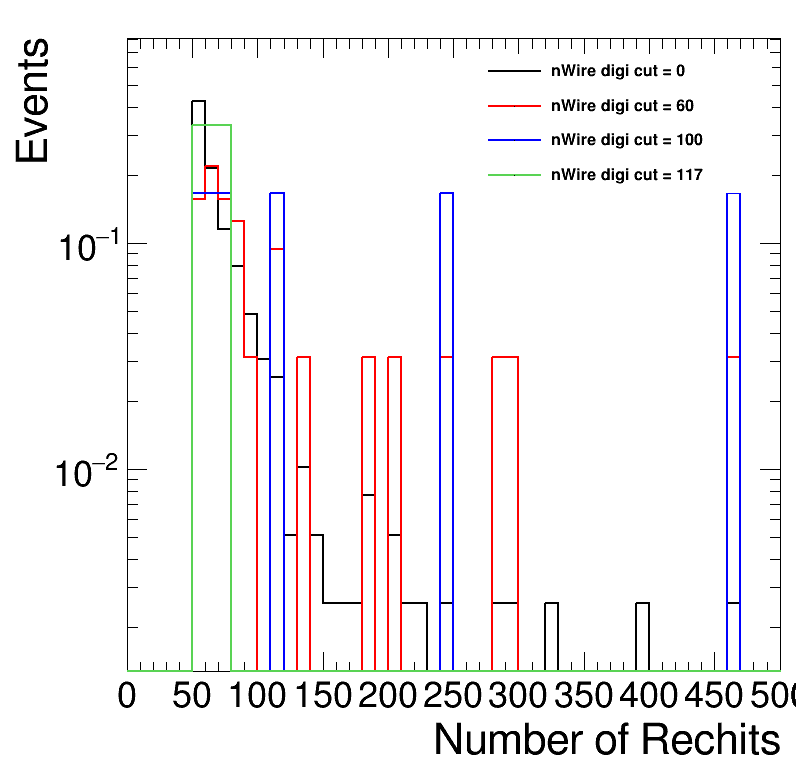

In [19]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.60,0.75,0.97,0.93)
# leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0
k = 'bkg'
bins = [100,0,150]
wiredigi_cut = [0,60,100,117]
for i, cut in enumerate(wiredigi_cut):
    print()
    v = nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k][nCscWireDigis[k]> cut].flatten()
    v = v[v != 0]
    h[str(cut)] = create_TH1D( v, axis_title=['Number of Rechits', 'Events'], name=k, binning=[50,0,500])


    h[str(cut)].SetLineColor(std_color_list[i])


    leg.AddEntry(h[str(cut)], "nWire digi cut = "+str(cut))
#     h[k].SetMinimum(0.1)
#     maximum = max(maximum, h[k].GetMaximum() )
#     h[k].SetMaximum(maximum * 20)
#     h[k].GetXaxis().SetLabelSize(0.04)
    h[str(cut)].DrawNormalized('same hist')
    #     h['seg'].DrawNormalized('same hist')




#     h[k].GetXaxis()


leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# signal efficiency turn on 

[133.81788079470198, 2245.1666666666665, 10103.25]
dict_keys(['100'])
dict_keys(['100', '200'])
dict_keys(['100', '200', '300'])
CPU times: user 196 ms, sys: 79.4 ms, total: 276 ms
Wall time: 292 ms


Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).


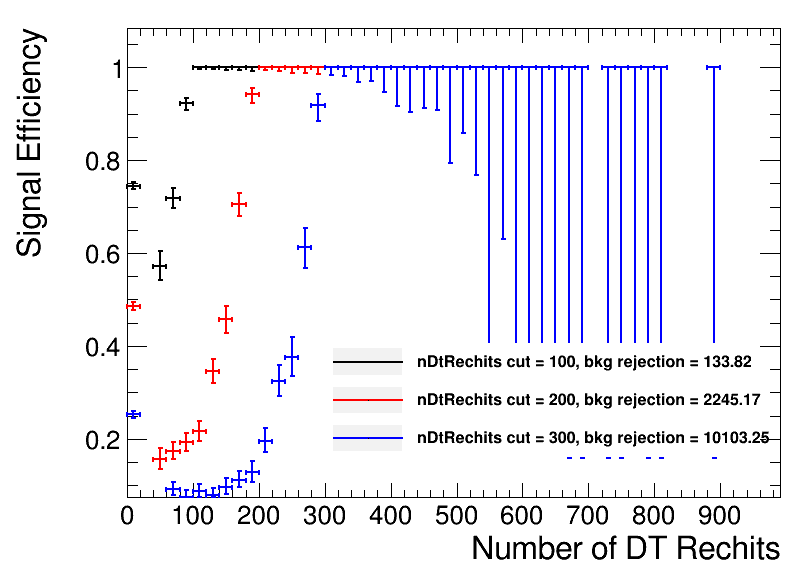

In [5]:
%%time 

c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.4,0.20,0.9,0.4)
leg.SetTextSize(0.03)

leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
k = 'sig'
xaxis_title = 'Number strip digis'
bins = [100,0,1000]
wire = []
strip = []
eff = []
# threshold = [60,80, 100,117]
# bkg_rej = [100, 285, 600, 1000]


threshold = [100,200,300]
var = nDtRechits
name = 'nDtRechits'
xaxis = nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]



# threshold = [60,179,211]
# var = nCscWireDigis_maxChamber2 #var to cut on
# name = 'nCscWireDigis'
# xaxis = nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]


bkg_rej = []


for th in threshold:
    temp = 1.0*len(var['bkg'])/np.count_nonzero(var['bkg']>th)
    bkg_rej.append(temp)
print(bkg_rej)
pEff1 = {}
for i,th_wire in enumerate(threshold):
    hm = create_TH1D( xaxis[var[k]>th_wire].flatten(), axis_title=['Number of DT Rechits', 'Signal Efficiency'], name=k, binning=[100,0,2000])
    hb = create_TH1D( xaxis.flatten(), axis_title=['Number of DT Rechits', 'Signal Efficiency'], name=k, binning=[100,0,2000])
    pEff1[str(th_wire)] = rt.TEfficiency(hm,hb)
    pEff1[str(th_wire)].SetLineColor(std_color_list[i])
    pEff1[str(th_wire)].SetLineWidth(2)
    pEff1[str(th_wire)].Draw('' if i == 0 else 'same')
    leg.AddEntry(pEff1[str(th_wire)], name+' cut = '+str(th_wire)+", bkg rejection = "+str(round(bkg_rej[i],2)))
    print(pEff1.keys())
leg.Draw()
c.Draw()


    

# 1D histogram

sig 0.4% signal efficiency 1 1.25
bkg 100 bkg rejection 0 1.25
0.322479248046875


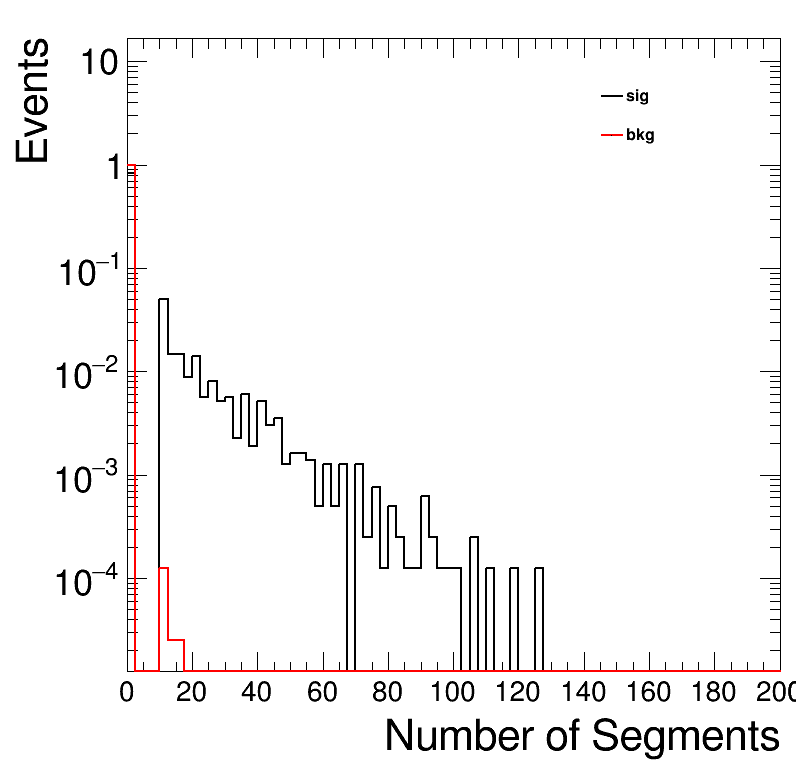

In [4]:
# Plotting nDt
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0

for i, k in enumerate(keys):
    bins = [100,-100,150]
#     h[k] = create_TH1D( dtRechitClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=[100,600,900])
#     if k == 'sig': continue
#     h[k] = create_TH1D( nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['Number of Rechits', 'Events'], name=k, binning=[100,0,1000])
    h[k] = create_TH1D( nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['Number of Segments', 'Events'], name=k, binning=[80,0,200])
#     h[k] = create_TH1D( nDtRechitCluster_JetMuonVetoCluster0p4[k].flatten(), axis_title=['Number of Rechits', 'Events'], name=k, binning=[100,0,1000])
#     h[k] = create_TH1D( nDtRechits[k], axis_title=['Number of DT Rechits', 'Events'], name=k, binning=[100,0,1000])


#     h[k] = create_TH1D( nDtRechits[k], axis_title=['Number of Rechits', 'Events'], name=k, binning=[5000,0,5000])
#     h[k] = create_TH1D( nDtWireDigis[k], axis_title=['Number of Wire Digis', 'Events'], name=k, binning=[1000,0,1000])

    if k == 'bkg':
        eff = 0
        for j in range(h[k].GetNbinsX()):
            eff += h[k].GetBinContent(j+1)
            if 1.0*eff/h[k].Integral() > 0.99:
                print(k,"100 bkg rejection",j, h[k].GetBinCenter(j+1))
                break
    else:
        eff = 0
        for j in range(h[k].GetNbinsX(),0,-1):
            eff += h[k].GetBinContent(j)
            if 1.0*eff/h[k].Integral() > 0.5:
                print(k,"0.4% signal efficiency",j, h[k].GetBinCenter(j))
                break
#     h[k] = create_TH1D( dtSegClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    h[k].SetLineColor(std_color_list[i])


    leg.AddEntry(h[k], k)
    h[k].SetMinimum(0.1)
    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 20)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
#     h['seg'].DrawNormalized('same hist')




#     h[k].GetXaxis()


leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# compare different bunch crossing

0.0014736652374267578


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


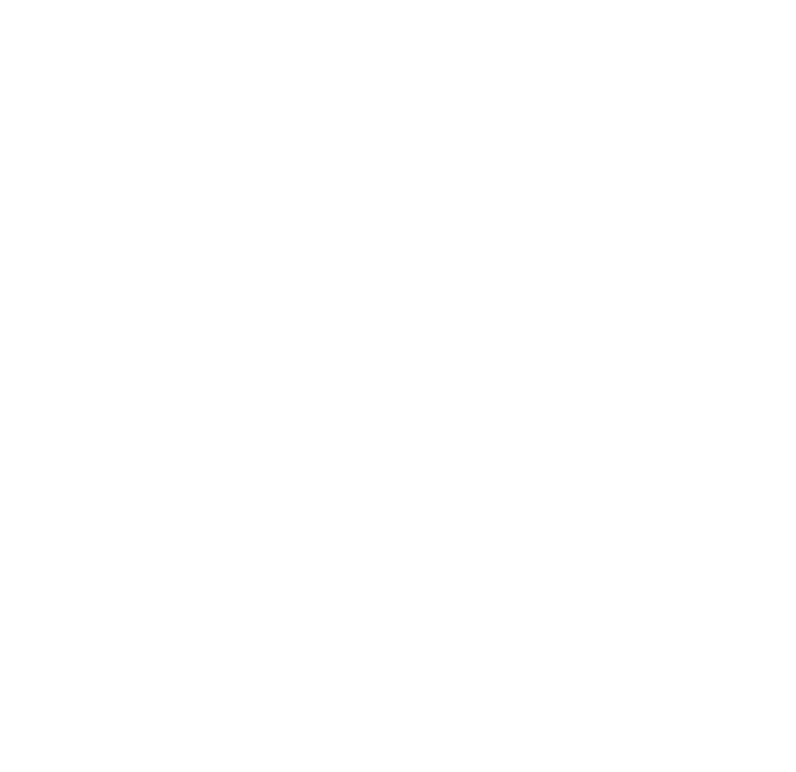

In [94]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0
i = 0
for k, v in selections_rechitcluster.items():
    if k == 'signal' or k == 'oot1': continue
    sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 0
    decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
    decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
    cond1 = np.logical_and(decay_distance0 < 100, decay_distance1 < 100)
    cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
    sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))
    sel_ev = np.logical_and(sel_ev, (v.sum()) >= 1)
#     cscRechitClusterSize[k] = T.array('cscSegClusterSize')[v][sel_ev]


    cscRechitClusterSize[k] = T.array('cscRechitClusterSize')[v][sel_ev]
    bins = [100,-100,150]
#     print(cscRechitClusterTime[k].flatten())
#     h[k] = create_TH1D( cscRechitClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    bins = [50,0,500]
    if k == 'sig': continue
    h[k] = create_TH1D( cscRechitClusterSize[k].sum(), axis_title=['nCsc rechits', 'Events'], name=k, binning=bins)
#     h[k] = create_TH1D( nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['nCsc rechits', 'Events'], name=k, binning=bins)



#     h[k] = create_TH1D( cscSegClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    h[k].SetLineColor(std_color_list[i])


    leg.AddEntry(h[k], k)
    h[k].SetMinimum(0.1)
    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
#     h['seg'].DrawNormalized('same hist')

    i += 1


#     h[k].GetXaxis()


leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# ROC Curve

dict_keys(['sig', 'bkg'])
(12,) (12,)
[5.65911546e-04 5.65911546e-04 5.65911546e-04 5.65911546e-04
 5.65911546e-04 4.80167373e-04 2.57232521e-04 2.05786017e-04
 1.71488347e-04 8.57441737e-05 6.85953389e-05 1.71488347e-05] [0.30190188 0.30190188 0.30190188 0.30190188 0.30190188 0.27648418
 0.23515819 0.20902951 0.18538926 0.17081408 0.15561678 0.1397085 ]
sig nDtRechitCluster_JetMuonVetoCluster0p4 1767.060606060606
0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


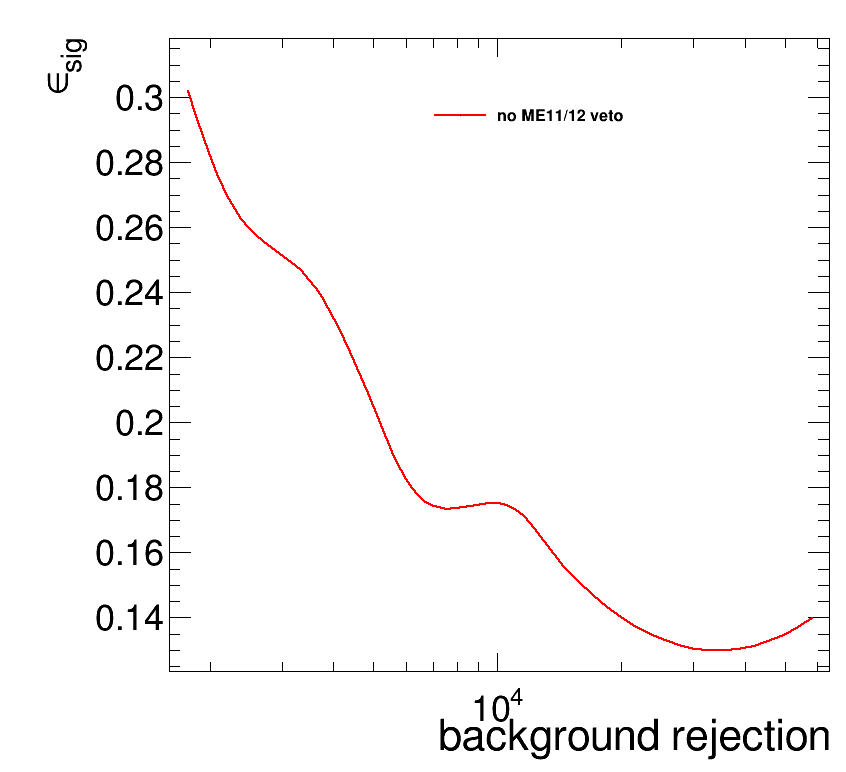

In [74]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.80,0.85,0.90)
# leg = rt.TLegend(0.3,0.80,0.55,0.90)


leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}

# var = [ nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto, nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto,]
# name =['RecHits', 'Segments', ]
# label = ['RecHits', 'Segments',]

# var = [ nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto, nDtRechitCluster_JetMuonVetoCluster0p4,]
var = [ nDtSegCluster_JetMuonVetoCluster0p4_Me1112Veto, nDtSegCluster_JetMuonVetoCluster0p4,]

label =['ME11/12 veto', 'no ME11/12 veto', ]
name = ['nDtRechitCluster_JetMuonVetoCluster0p4_Me1112Veto', 'nDtRechitCluster_JetMuonVetoCluster0p4',]


qcd_key = 'DYJetsToLL'
for i in range(len(var)):
    if i == 0: continue
#     if i == 0:
#     thre = np.array(range(50))*2
#     else:
#         thre = np.array(range(100))
#     thre = np.array(range(50))*2

    thre = np.array(range(25))*2


    print(var[i].keys())
    eff = {}
    for k in var[i].keys():

        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(var[i][k].flatten()>th)/len(var[i][k].flatten()))
        eff[k] = np.array(eff[k])
    #Plotting ROC curve
    eff['sig'] = eff['sig'][np.logical_not(eff['bkg'] <= 0)]
    eff['bkg'] = eff['bkg'][np.logical_not(eff['bkg'] <= 0)]
    print(eff['bkg'].shape, eff['sig'].shape)
    print(eff['bkg'], eff['sig'])
    #         gr[name[i]+sig_k] = create_TGraph(eff[sig_k],eff[qcd_key],axis_title = ['#epsilon_{sig}','background efficiency'])


    gr[name[i]] = create_TGraph(np.reciprocal(eff['bkg']),eff['sig'],axis_title = ['background rejection','#epsilon_{sig}'])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineWidth(2)
#     gr[name[i]].GetYaxis().SetTitleOffset(1.5)

#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)

    leg.AddEntry(gr[name[i]],label[i])




#     gr[name[i]].GetYaxis().SetLimits(0.1, 0.2)
    gr[name[i]].Draw('ac' )
#     gr[name[i]].SetMaximum(1.0);
#     gr[name[i]].SetMinimum(0.);






    c.Update()

    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.3 #target signal efficiency
    ind = np.abs(eff['sig']-value).argmin()
#     ind = 110
    print('sig',name[i],1.0/eff['bkg'][ind])
#         print(name[i],eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

# 2D plots per event

0.004029750823974609


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


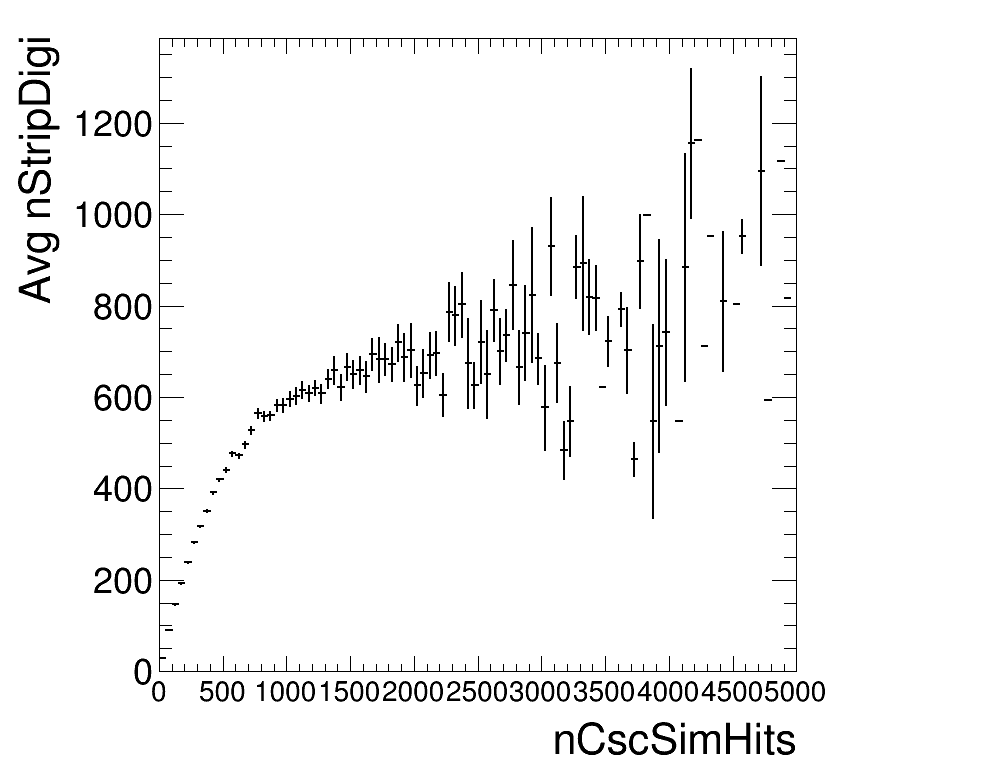

In [75]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'
cond = gLLP_csc[k]
# cond = cscDetLayer_nCscSimHits[k]*0+cond
# cond = cond.flatten()
# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,800,200,0,3000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,800,250,0,3000])
h[k] = create_TH2D(np.column_stack((nCscSimHits[k][cond >= 1],nCscStripDigis[k][cond >= 1])), axis_title = ['nCscSimHits','nStripDigis','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((nCscSimHits[k][cond],nCscRecHits[k][cond])), axis_title = ['nCscSimHits','nCscRecHits','Events'], binning=[150,0,2000,150,0,2000])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond==0 ], cscDetLayer_nCscRecHits[k].flatten()[cond ==0 ])), axis_title = ['nCscSimHits','nCscRecHits','Events'], binning=[150,0,1000,150,0,600])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nWireDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscWireDigis','Events'], binning=[150,0,1000,100,0,100])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nStripDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscStripDigis','Events'], binning=[150,0,1000,100,0,100])



# h[k] = create_TH2D(np.column_stack((nCscRecHits[k][cond],nCscSimHits[k][cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,2000,150,0,2000])



# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])
h[k] = h[k].ProfileX()


# r = h[k].Fit('pol1', 'LRSQ+', '', 100,400)
# print(r.Get())
# print(r.Prob())
# h[k].GetFunction("pol1").SetLineColor(std_color_list[2])
# h[k].GetFunction("pol1").SetLineWidth(2)

h[k].GetXaxis().SetLabelSize(0.04)
h[k].GetYaxis().SetTitle('Avg nStripDigi')




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# 2D plots per layer

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'


cond = gLLP_csc[k]
cond = cscDetLayer_nCscRecHits[k]*0+cond
cond = cond.flatten()
cond = (cond == 1)
# print(len(cond),np.count_nonzero(cond))
# print(len(cscDetLayer_nWireDigis[k].flatten()))
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,100,100,0,500])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nStripDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[50,0,100,50,0,100])


# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,100,250,0,1000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nStripDigis','nCscSimHits','Events'], binning=[100,0,5000,200,0,3000])

h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscRecHits[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,200,150,0,800])

print(np.unique(cscDetLayer_nStripDigis[k].flatten()[cond]))
print(np.unique(cscDetLayer_nWireDigis[k].flatten()[cond]))


# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])

h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# SimHit distribution per Layer

20
21
15
19
0
0
[139.24751 137.23349 137.27115 138.99098 138.90771 137.15454 142.48595
 143.86221 149.5309  146.94652 147.00357 148.71863 147.03104 146.97783
 146.92065 133.37749 140.882   141.11513 134.65558 134.87656]
[-530.8045  -531.1113  -530.9534  -528.7419  -528.76105 -526.53644
 -548.13464 -545.5549  -556.1927  -558.4537  -558.67346 -568.353
 -559.07477 -557.6948  -557.789   -522.0904  -546.69196 -546.5215
 -518.37134 -518.3311 ]
[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
20.0 20 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 3.57 s, sys: 2.68 s, total: 6.25 s
Wall time: 6.23 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


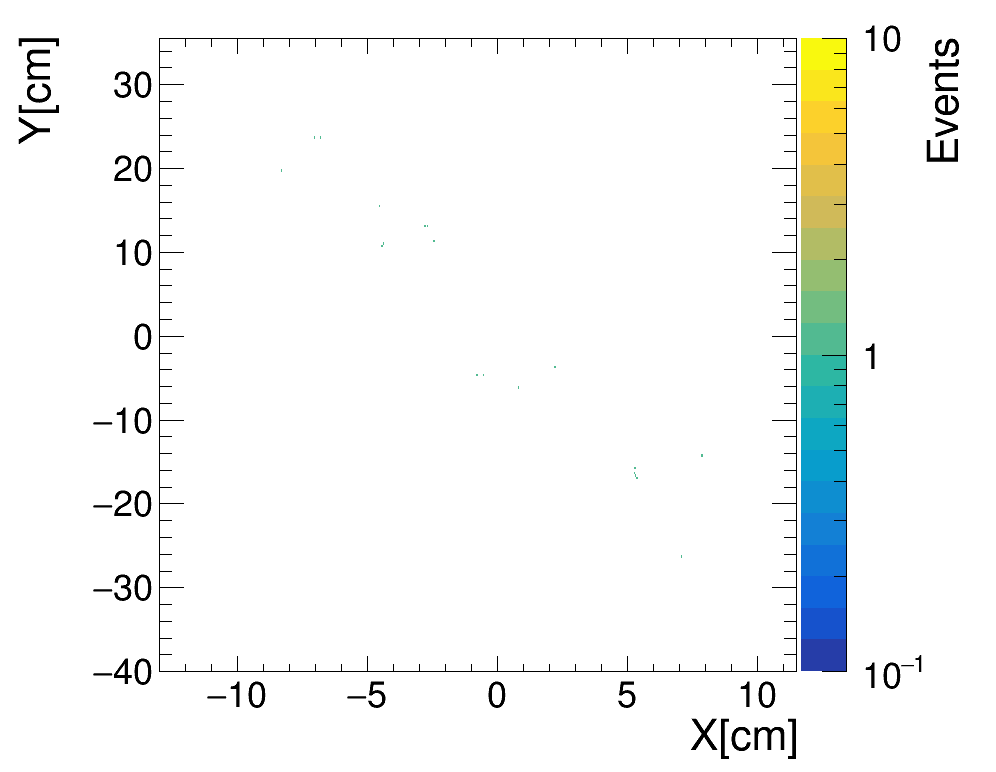

In [58]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

ev = 88785
detid = 604058214
ev = 134356  
detid = 604058858
#   22 12 403 647 1

#   26 20 177 125 1
#   17 0 64 70 1

ev_cond = eventNum[k] == ev
cond = cscSimHitsDetId[k][ev_cond] == detid+1
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+3][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-3][0]))



meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

print(cscSimHitsX[k][ev_cond][cond][0])
print(cscSimHitsY[k][ev_cond][cond][0])
# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 +1
xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 -1
ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 30,-30,20,-20

xnbin = (xmax-xmin)/0.05
ynbin = (ymax-ymin)/0.3
bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)

h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
[-78.8824    -76.30316   -74.19941    -7.184723   -1.6389618   2.8841248
  -4.611862    1.0366974   5.6436768  -1.5316925   4.2421417   8.950912 ]
9.0 9 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 1.3 s, sys: 1.11 s, total: 2.41 s
Wall time: 2.4 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


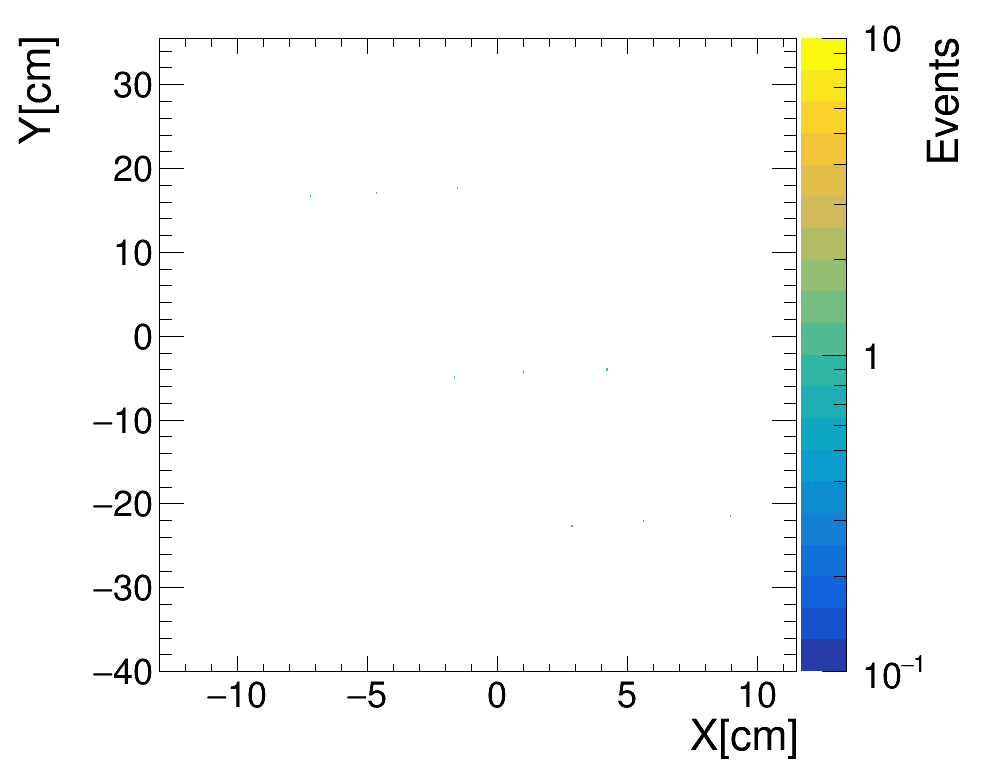

In [59]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

# ev = 17344  
# detid = 604021398

ev_cond = eventNum[k] == ev

cond = cscRecHitsDetId[k][ev_cond] == detid


# meanx = np.mean(cscRecHitsX[k][ev_cond][cond][0])
# meany = np.mean(cscRecHitsY[k][ev_cond][cond][0])
# meanz = np.mean(cscRecHitsZ[k][ev_cond][cond][0])


# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
# xmax = int(np.max(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# xmin = int(np.min(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# ymax = int(np.max(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
# ymin = int(np.min(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 40,-40,40,-40

# xnbin = (xmax-xmin)
# ynbin = (ymax-ymin)
# bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscRecHitsX[k][ev_cond][cond][0]-meanx,cscRecHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
print(cscRecHitsX[k][ev_cond][cond][0]-meanx)
h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

# Occupancy plot

CPU times: user 470 µs, sys: 0 ns, total: 470 µs
Wall time: 479 µs


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


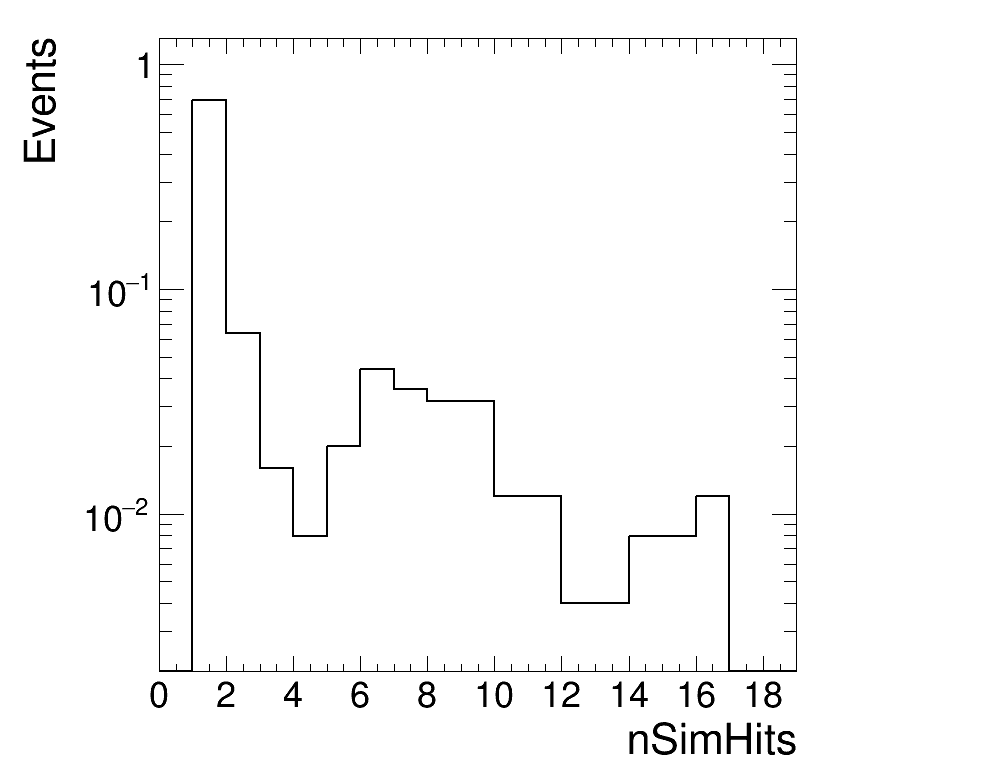

In [53]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)




histo.DrawNormalized('')
c.SetLogy()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()



# Occupancy per event

In [ ]:
avg_occupancy = []
max_occupancy = []
for i in range(len(eventNum[k])):
    if len(cscDetLayer_nCscSimHits[k][i]) == 0: continue
    max_index = np.argmax(cscDetLayer_nCscSimHits[k][i])

#     if cscDetLayer_nCscSimHits[k][i][max_index]>750 and gLLP_csc[k][i] == 1:
#         print(ev,cscDetLayer[k][i][max_index],cscDetLayer_nCscSimHits[k][i][max_index], nCscSimHits[k][i], gLLP_csc[k][i])

    cond = cscSimHitsDetId[k][ev_cond] == detid
    meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
    meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
    meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

    xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
    ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
    # xmax,xmin,ymax,ymin = 20,-20,20,-20

    xnbin = (xmax-xmin)/0.05
    ynbin = (ymax-ymin)/0.3
    bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
#     print(bins)
#     print(meanx,meany,meanz)
#     print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
    h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
    # print(cscSimHitsY[k][ev_cond][cond][0])


    ll = []
    for i in range(1,h[k].GetNbinsX() + 1):
        for j in range(1,h[k].GetNbinsY() + 1):
            temp = h[k].GetBinContent(i,j)
            if temp > 0:
                ll.append(temp)
    print(sum(ll),ll)
    histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

# significance